## **1. Input Data and Configuration**

---

Define the essential parameters for the analysis in the code cell below. You must specify the input and output directories, the time range for the study, and the category metadata.

**Raster File Requirements:**
Ensure that all input raster images reside in the defined `input_dir`. You must name the files such that they end with the four-digit year followed by the `.tif` extension (e.g., `landcover_1990.tif` or simply `1990.tif`). The script relies on this pattern to correctly associate each file with its corresponding year.

**Parameters to Configure:**
* **`input_dir`**: The absolute path to the folder containing the time series of raster images.
* **`years`**: A list of integers representing the specific years you wish to analyze (e.g., `range(1985, 2022)`).
* **`cclass_labels_dict`**: A dictionary mapping the integer pixel values (IDs) to their class names and specific hex colors for visualization.
* **`output_path`**: The destination directory where the script will save all generated CSV tables, figures, and GeoTIFF maps.

### 1.1 Import libraries and functions

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from utils import (
    plot_classified_images,
    generate_component_summary,
    plot_change_components,
    generate_trajectory_map,
    plot_pixel_counts,
    generate_all_matrices,
    plot_decomposed_transitions
)

### 1.2 Define input raster maps and configuration parameters

In [15]:
# Directory containing the rasters
input_dir = r"/Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/dataset/vcr"

# Define the specific years to process
years = list(
    range(
        1989,
        2022
    )
)

# Define the value representing no data in the rasters
noData_value = 255

In [16]:
# Construct file paths dynamically based on the years list
# Searches for any file ending in {year}.tif within the directory
image_paths = []
for year in years:
    search_pattern = os.path.join(
        input_dir,
        f"*{year}.tif"
    )
    found_files = glob.glob(
        search_pattern
    )
    
    # Take the first matching file for the year
    if found_files:
        image_paths.append(
            found_files[0]
        )

# Print the count of found files
print(
    f"Total images found: {len(image_paths)}"
)

# Print the filename of each found raster
for path in image_paths:
    print(
        os.path.basename(
            path
        )
    )

Total images found: 33
vcr_1989.tif
vcr_1990.tif
vcr_1991.tif
vcr_1992.tif
vcr_1993.tif
vcr_1994.tif
vcr_1995.tif
vcr_1996.tif
vcr_1997.tif
vcr_1998.tif
vcr_1999.tif
vcr_2000.tif
vcr_2001.tif
vcr_2002.tif
vcr_2003.tif
vcr_2004.tif
vcr_2005.tif
vcr_2006.tif
vcr_2007.tif
vcr_2008.tif
vcr_2009.tif
vcr_2010.tif
vcr_2011.tif
vcr_2012.tif
vcr_2013.tif
vcr_2014.tif
vcr_2015.tif
vcr_2016.tif
vcr_2017.tif
vcr_2018.tif
vcr_2019.tif
vcr_2020.tif
vcr_2021.tif


In [17]:
# Class ID, names, and colors
class_labels_dict = {
     0: {"name": "No Data",   "color": "#d870b2"},
     1: {"name": "Water",     "color": "#003ba1"},
     2: {"name": "Shrubs",    "color": "#c9cc3f"},
     3: {"name": "Tidal flat","color": "#c9712b"},
     4: {"name": "Low marsh", "color": "#ffd700"},
     5: {"name": "High marsh","color": "#6b6e7c"},
     6: {"name": "Barren",    "color": "#ffdead"},
     7: {"name": "Tree",      "color": "#228b22"}
}

# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["name"] for key in sorted(class_labels_dict.keys())]

### 1.3 Define output directory

In [18]:
# Output directory path
output_path = r"/Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC"

# Create folder if it does not exist
if not os.path.exists(
    output_path
):
    os.makedirs(
        output_path
    )

### 1.4 Plot raster maps for visual inspection

In [ ]:
# Visualize the input rasters
# We pass 'class_labels_dict' to the 'class_map' argument
plot_classified_images(
    class_map=class_labels_dict,
    years=years,
    output_path=output_path,
    image_paths=image_paths,
    cols_disp=4
)

## **2.Pixel Count Analysis**

---

Execute the pixel count analysis in the code cell below. The script aggregates the total number of pixels for each land cover category across the entire time series.

**Outputs Generated:**
* **Stacked Bar Chart:** A visualization of class composition changes over time (`pixels_per_class_bar.png`).
* **CSV Report:** A tabular file containing the raw pixel counts for every class and year (`pixels_per_class_per_year.csv`), saved in the defined output directory.

In [ ]:
# Execute Pixel Count Analysis
plot_pixel_counts(
    image_paths=image_paths,
    years=years,
    class_labels_dict=class_labels_dict,
    output_path=output_path,
)

## **3.Generate the Transition Matrix**


---
Execute the code below to generate the transition matrices required for the change component analysis. The script performs a hybrid decomposition to differentiate between **Extent** (changes observed between the start and end) and **Alternation** (changes occurring during intermediate time intervals).

**Data Pre-processing:**
Before calculation, the function automatically identifies invalid values (0, NULL, or NA) across all input rasters. It applies a unified mask to remove these pixels from every time point, ensuring that the analysis runs only on valid, consistent spatial locations.

**Outputs Generated:**
The script saves the following CSV files to your output directory:
* **Interval Matrices:** Individual transition matrices for each consecutive time interval (e.g., `1989-1990`).
* **Extent Matrix:** A transition matrix comparing the first time point directly to the last time point.
* **Sum Matrix:** The summation of all individual interval matrices.
* **Alternation Matrix:** Calculated by subtracting the Extent matrix from the Sum matrix. This represents the changes that occur during intermediate time intervals but are not captured by the Extent matrix.

In [10]:
# Execute the matrix generation process
# Note: We pass 'image_paths' explicitly to ensure only the selected years (e.g., 1989-2021) are processed.
years_processed, classes_found = generate_all_matrices(
    input_path=input_dir,
    output_path=output_path,
    suffix=".tif",
    image_paths_arg=image_paths
)

print(f"Matrix generation complete.")
print(f"Time range processed: {years_processed[0]} - {years_processed[-1]}")
print(f"Classes found: {classes_found}")

Reading rasters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 44.86raster/s]


Processing 5547040 pixels for transitions...


Processing Pixels: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5547040/5547040 [01:44<00:00, 52912.94it/s]


Matrix generation complete.
Time range processed: 1989 - 2021
Classes found: [0 1 2 3 4 5 6 7]


## **4.Heatmap Visualizations of Transition Matrices**

---

The following code visualizes the generated transition matrices as heatmaps. These visual representations allow for a quick assessment of the major transitions between categories.

**Matrices Visualized:**
* **Sum:** Shows the total accumulation of transitions across all intervals.
* **Extent:** Shows the transitions directly from the first year to the last year.
* **Alternation (Exchange & Shift):** Visualizes the components of change that are "hidden" when looking only at the start and end years.

Values in the heatmap represent the number of pixels. 'k' denotes thousands and 'M' denotes millions.un the code cell below to create heatmap visualizations for each of the transition matrices generated in

Saved plot: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/heatmap_ALLOCATION_EXCHANGE_1989-2021.png


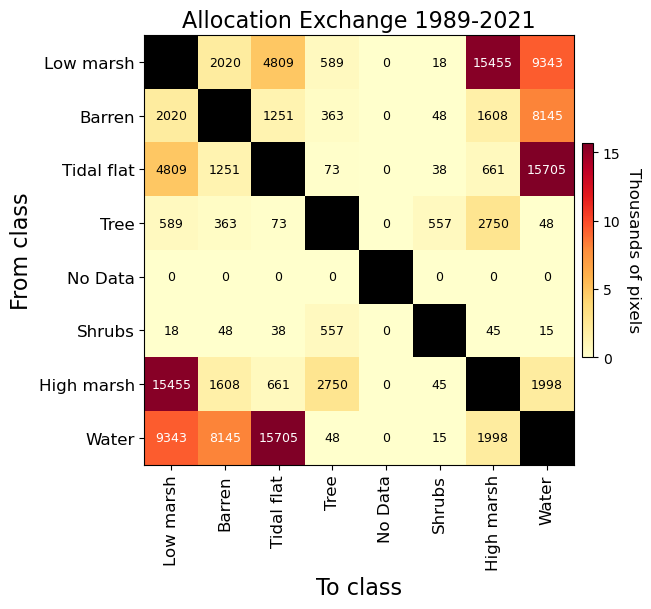

Saved plot: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/heatmap_ALLOCATION_SHIFT_1989-2021.png


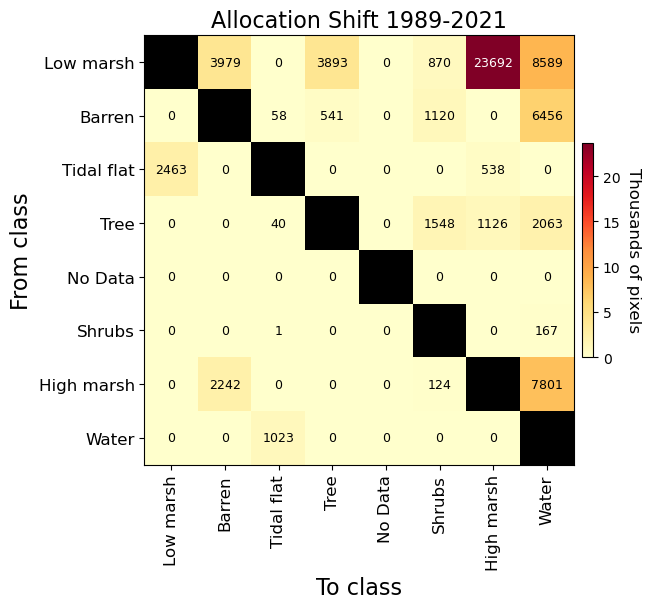

Saved plot: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/heatmap_ALTERNATION_EXCHANGE_1989...2021.png


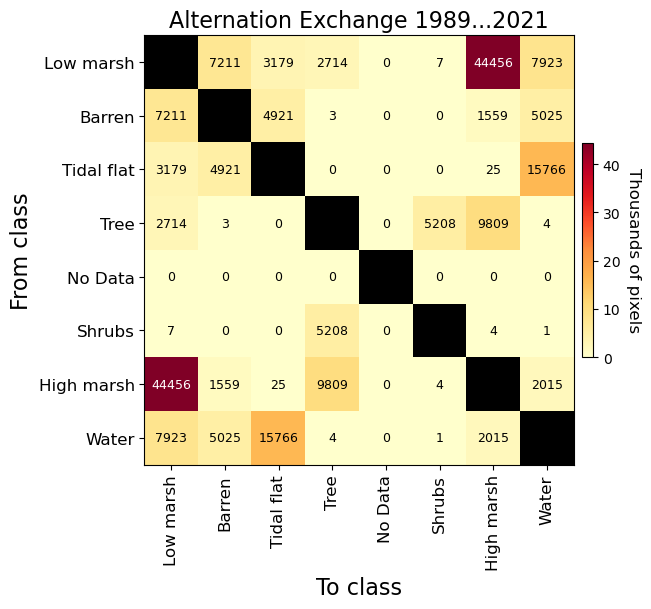

Saved plot: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/heatmap_ALTERNATION_SHIFT_1989...2021.png


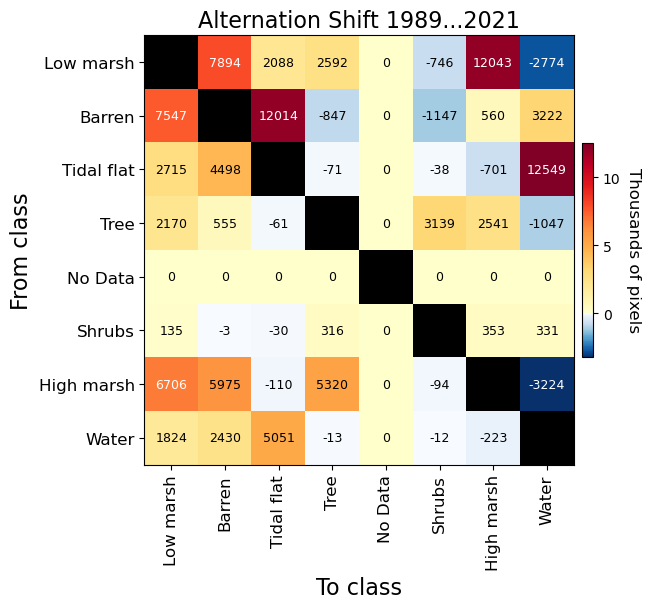

In [11]:
# Execute the visualization of the decomposed matrices
# This function handles loading, sorting (by net change), and plotting automatically.
plot_decomposed_transitions(
    output_path=output_path,
    years=years,
    class_labels_dict=class_labels_dict
)

## **5. Components of Change Analysis**

In this section, we decompose the landscape changes into **Quantity**, **Exchange**, and **Shift** components, following the methodology proposed by Pontius Jr. and da Fonseca (2025).

The analysis quantifies:
1.  **Quantity:** The net difference in the size of the category (Net Gain or Net Loss).
2.  **Exchange:** The component of difference attributable to simultaneous gain and loss between categories (direct swapping).
3.  **Shift:** The component of difference that is neither Quantity nor Exchange (locational changes that do not involve reciprocal swapping).

Furthermore, to provide a complete temporal analysis, these components are aggregated into:
* **Allocation:** Difference in Allocation (Sum of Quantity + Exchange + Shift from the *Extent* matrix).
* **Alternation:** Difference in Alternation (Changes that oscillate and return to the original category).

In [ ]:
# Prerequisite: Ensure that 'output_path', 'years', and 'class_labels_dict' are defined.
print(f"Generating component summary for the period: {years[0]}-{years[-1]}...")

# This function reads the existing transition matrices (Sum, Extent, Alternation)
# and calculates the aggregated totals for Quantity, Exchange, and Shift per class.
df_components = generate_component_summary(
    output_path=output_path,
    years=years,
    class_labels_dict=class_labels_dict 
)

# The function automatically saves the result to a CSV file (e.g., "change_components_summary.csv").
# We print a confirmation and display the first few rows for verification.
print("Component summary file generated successfully!")
display(df_components.head())

Gerando resumo de componentes para o período: 1989-2021
Summary components (adjusted) saved to: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/change_components_summary.csv
Arquivo de componentes gerado com sucesso!
  Time_Interval    Class Component  Gain  Loss
0     1989-1990  No Data  Quantity   0.0   0.0
1     1989-1990  No Data  Exchange   0.0   0.0
2     1989-1990  No Data     Shift   0.0   0.0
3     1990-1991  No Data  Quantity   0.0   0.0
4     1990-1991  No Data  Exchange   0.0   0.0


### **5.1 Visualization of Change Components**

This section visualizes the components of change (Allocation and Alternation) calculated in the previous step. We generate a stacked bar chart showing the **Gains** and **Losses** for each category, decomposed into:

* **Quantity:** Net change in category size.
* **Allocation Shift:** Locational changes without swapping (Net allocation change).
* **Allocation Exchange:** Simultaneous swapping between categories (Allocation).
* **Alternation Shift:** Shift component within the oscillating changes.
* **Alternation Exchange:** Exchange component within the oscillating changes.

#### Change Components by Time Interval

Plotting change components over time intervals...
Time interval plot saved to: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/graphic_change_components_time_interval.jpeg


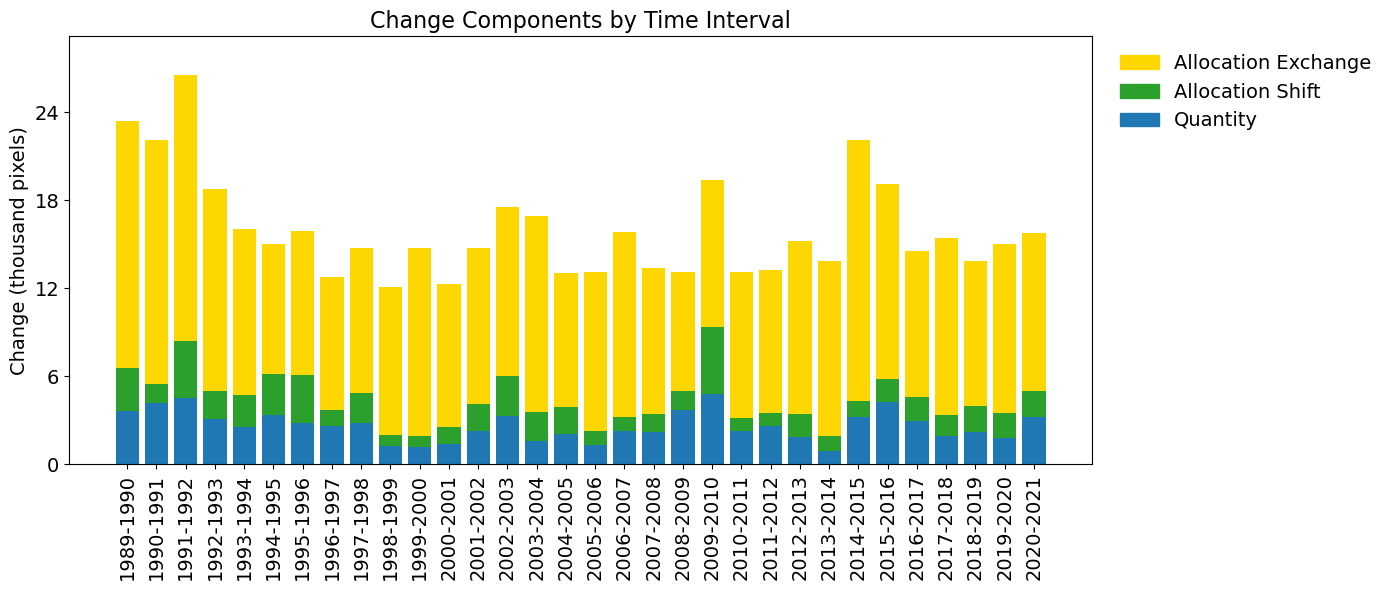

In [ ]:
print("Plotting change components over time intervals...")

# 1. Filter data for annual time intervals only (exclude aggregated periods)
# Uses the 'df_components' dataframe generated in the previous step
time_df = df_components[
    df_components["Time_Interval"].str.contains("-")
].copy()

# 2. Aggregate totals per interval and component (using 'Gain' as absolute change)
totals = (
    time_df.groupby(
        ["Time_Interval", "Component"],
    )["Gain"]
    .sum()
    .unstack()
    .fillna(0) # Ensure no NaN values break the plot
)

# 3. Determine scale factor automatically based on max value
max_val = totals[["Quantity", "Shift", "Exchange"]].to_numpy().max()

if max_val >= 1_000_000:
    scale_factor = 1_000_000
    y_label = "Change (million pixels)"
elif max_val >= 1_000:
    scale_factor = 1_000
    y_label = "Change (thousand pixels)"
elif max_val >= 100:
    scale_factor = 100
    y_label = "Change (hundred pixels)"
else:
    scale_factor = 1
    y_label = "Change (pixels)"

# 4. Scale the data for plotting
scaled_totals = totals[
    [
        "Quantity",
        "Shift",
        "Exchange",
    ]
] / scale_factor

# Calculate maximum height for Y-axis limit
stacked_max = scaled_totals.sum(axis=1).max()

# 5. Create Plot
fig, ax = plt.subplots(
    figsize=(14, 6),
)

# Define Colors
colors = [
    "#1f77b4",  # Quantity (Blue)
    "#2ca02c",  # Shift (Green)
    "#ffd700",  # Exchange (Gold)
]
components_color = {
    "Quantity": "#1f77b4",
    "Shift": "#2ca02c",
    "Exchange": "#ffd700"
}

# 6. Plot Stacked Bars
# Order: Quantity (bottom), Shift (middle), Exchange (top)
stack_order = ["Quantity", "Shift", "Exchange"]

for idx, comp in enumerate(stack_order):
    # Calculate 'bottom' parameter for stacking
    if idx == 0:
        bottom_values = 0
    else:
        bottom_values = scaled_totals[stack_order[:idx]].sum(axis=1)
        
    ax.bar(
        totals.index,
        scaled_totals[comp],
        label=comp,
        color=colors[idx],
        edgecolor="none",
        bottom=bottom_values,
        width=0.8
    )

# 7. Format Axes
ax.set_ylabel(y_label, fontsize=14)
ax.set_title("Change Components by Time Interval", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=14)

# Adaptive X-axis labels rotation
labels = ax.get_xticklabels()
n_labels = len(totals.index)

if n_labels <= 6:
    rotation = 0
    ha = "center"
elif n_labels <= 15:
    rotation = 45
    ha = "right"
else:
    rotation = 90
    ha = "center"

plt.setp(
    labels,
    rotation=rotation,
    ha=ha
)

# Y-axis limits
y_max_scaled = stacked_max * 1.1 if stacked_max > 0 else 1.0
ax.set_ylim(0, y_max_scaled)
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# 8. Legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color=components_color["Exchange"], label="Allocation Exchange"),
    plt.Rectangle((0, 0), 1, 1, color=components_color["Shift"], label="Allocation Shift"),
    plt.Rectangle((0, 0), 1, 1, color=components_color["Quantity"], label="Quantity"),
]

ax.legend(
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(1.01, 1),
    fontsize=14,
    frameon=False,
)

plt.tight_layout()

# 9. Save and Show
save_path = os.path.join(
    output_path,
    "graphic_change_components_time_interval.jpeg"
)

plt.savefig(
    save_path,
    bbox_inches="tight",
    format="jpeg",
    dpi=300
)

print(f"Time interval plot saved to: {save_path}")

plt.show()

#### Change Components Overall

Plotting overall change components...
Overall components plot saved to: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/graphic_change_components_overall.jpeg


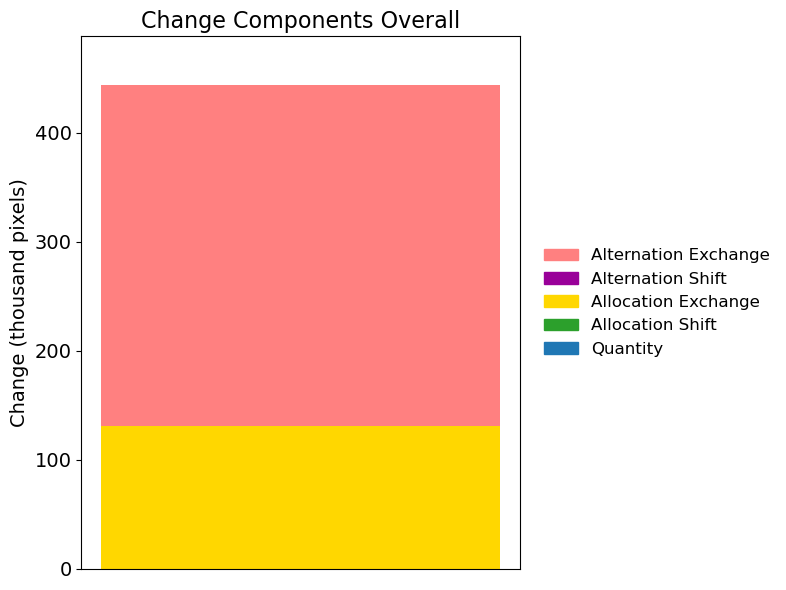

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Plot overall change components as a single stacked bar with auto-scaled y-axis.
    """
    
    # Verify file existence
    if not os.path.exists(csv_path):
        print(f"Error: CSV file not found at {csv_path}")
        return

    # Load data
    df = pd.read_csv(csv_path)

    # Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }
    
    component_order = [
        "Quantity",
        "Allocation_Shift",
        "Allocation_Exchange",
        "Alternation_Shift",
        "Alternation_Exchange"
    ]

    # Aggregate totals per component using specific logic for Extent vs Alternation
    # Allocation components are retrieved from the 'extent' interval rows.
    # Alternation components use specific filtering to capture magnitude.
    try:
        component_totals = {
            "Quantity": df[
                (df["Component"] == "Allocation_Quantity")
                & (df["Time_Interval"] == "extent")
            ]["Gain"].sum(),
            
            "Allocation_Exchange": df[
                (df["Component"] == "Allocation_Exchange")
                & (df["Time_Interval"] == "extent")
            ]["Gain"].sum(),
            
            "Allocation_Shift": df[
                (df["Component"] == "Allocation_Shift")
                & (df["Time_Interval"] == "extent")
            ]["Gain"].sum(),
            
            "Alternation_Exchange": df[
                (df["Time_Interval"] == "alternation_exchange") &
                (df["Gain"] > 0)
            ]["Gain"].sum(),
            
            # Logic summing Alternation Shift + negative Alternation Exchange (if any)
            "Alternation_Shift": df[
                (df["Time_Interval"] == "alternation_shift")
            ]["Gain"].sum() + df[
                (df["Time_Interval"] == "alternation_exchange") &
                (df["Gain"] < 0)
            ]["Gain"].sum(),
        }
    except KeyError as e:
        print(f"Error processing data: Missing expected column or value. Details: {e}")
        return

    # Automatic scale based on the sum of all stacked components
    total_change = sum(component_totals.values())

    if total_change >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif total_change >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    elif total_change >= 100:
        scale_factor = 100
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each component in a stacked bar at a single x-position
    bottom = 0.0
    for component in component_order:
        value = component_totals.get(component, 0.0) / scale_factor
        if value > 0:
            ax.bar(
                x=0,
                height=value,
                bottom=bottom,
                color=components_color[component],
                edgecolor="none",
                width=0.6,
                label=component # Add label for checking, though legend is custom
            )
            bottom += value

    # Axes formatting and labels
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title("Change Components Overall", fontsize=16)
    ax.xaxis.set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Set y-axis limits and major tick locators
    y_max_scaled = bottom * 1.1 if bottom > 0 else 1.0
    ax.set_ylim(0, y_max_scaled)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    
    # Configure visible spines
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(True)

    # Define custom legend elements
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, color=components_color["Alternation_Exchange"], label="Alternation Exchange"),
        plt.Rectangle((0, 0), 1, 1, color=components_color["Alternation_Shift"], label="Alternation Shift"),
        plt.Rectangle((0, 0), 1, 1, color=components_color["Allocation_Exchange"], label="Allocation Exchange"),
        plt.Rectangle((0, 0), 1, 1, color=components_color["Allocation_Shift"], label="Allocation Shift"),
        plt.Rectangle((0, 0), 1, 1, color=components_color["Quantity"], label="Quantity"),
    ]
    
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=12,
        frameon=False,
    )

    # Final layout adjustment and export
    plt.tight_layout()
    save_file = os.path.join(output_path, "graphic_change_components_overall.jpeg")
    plt.savefig(save_file, bbox_inches="tight", format="jpeg", dpi=300)
    print(f"Overall components plot saved to: {save_file}")
    plt.show()

# --- Execute Plotting ---
print("Plotting overall change components...")

# Note: We point to 'change_components_summary.csv' which was generated in Section 5
csv_file_path = os.path.join(output_path, "change_components_summary.csv")

plot_components_with_alternation(
    csv_path=csv_file_path,
    output_path=output_path
)

#### Change Components by Class

Plotting change components per category...
Components plot saved to: /Users/antoniofonseca/Library/CloudStorage/GoogleDrive-antoniovicgf@gmail.com/My Drive/change-components/output_vcr_CAC/graphic_change_components_per_class.png


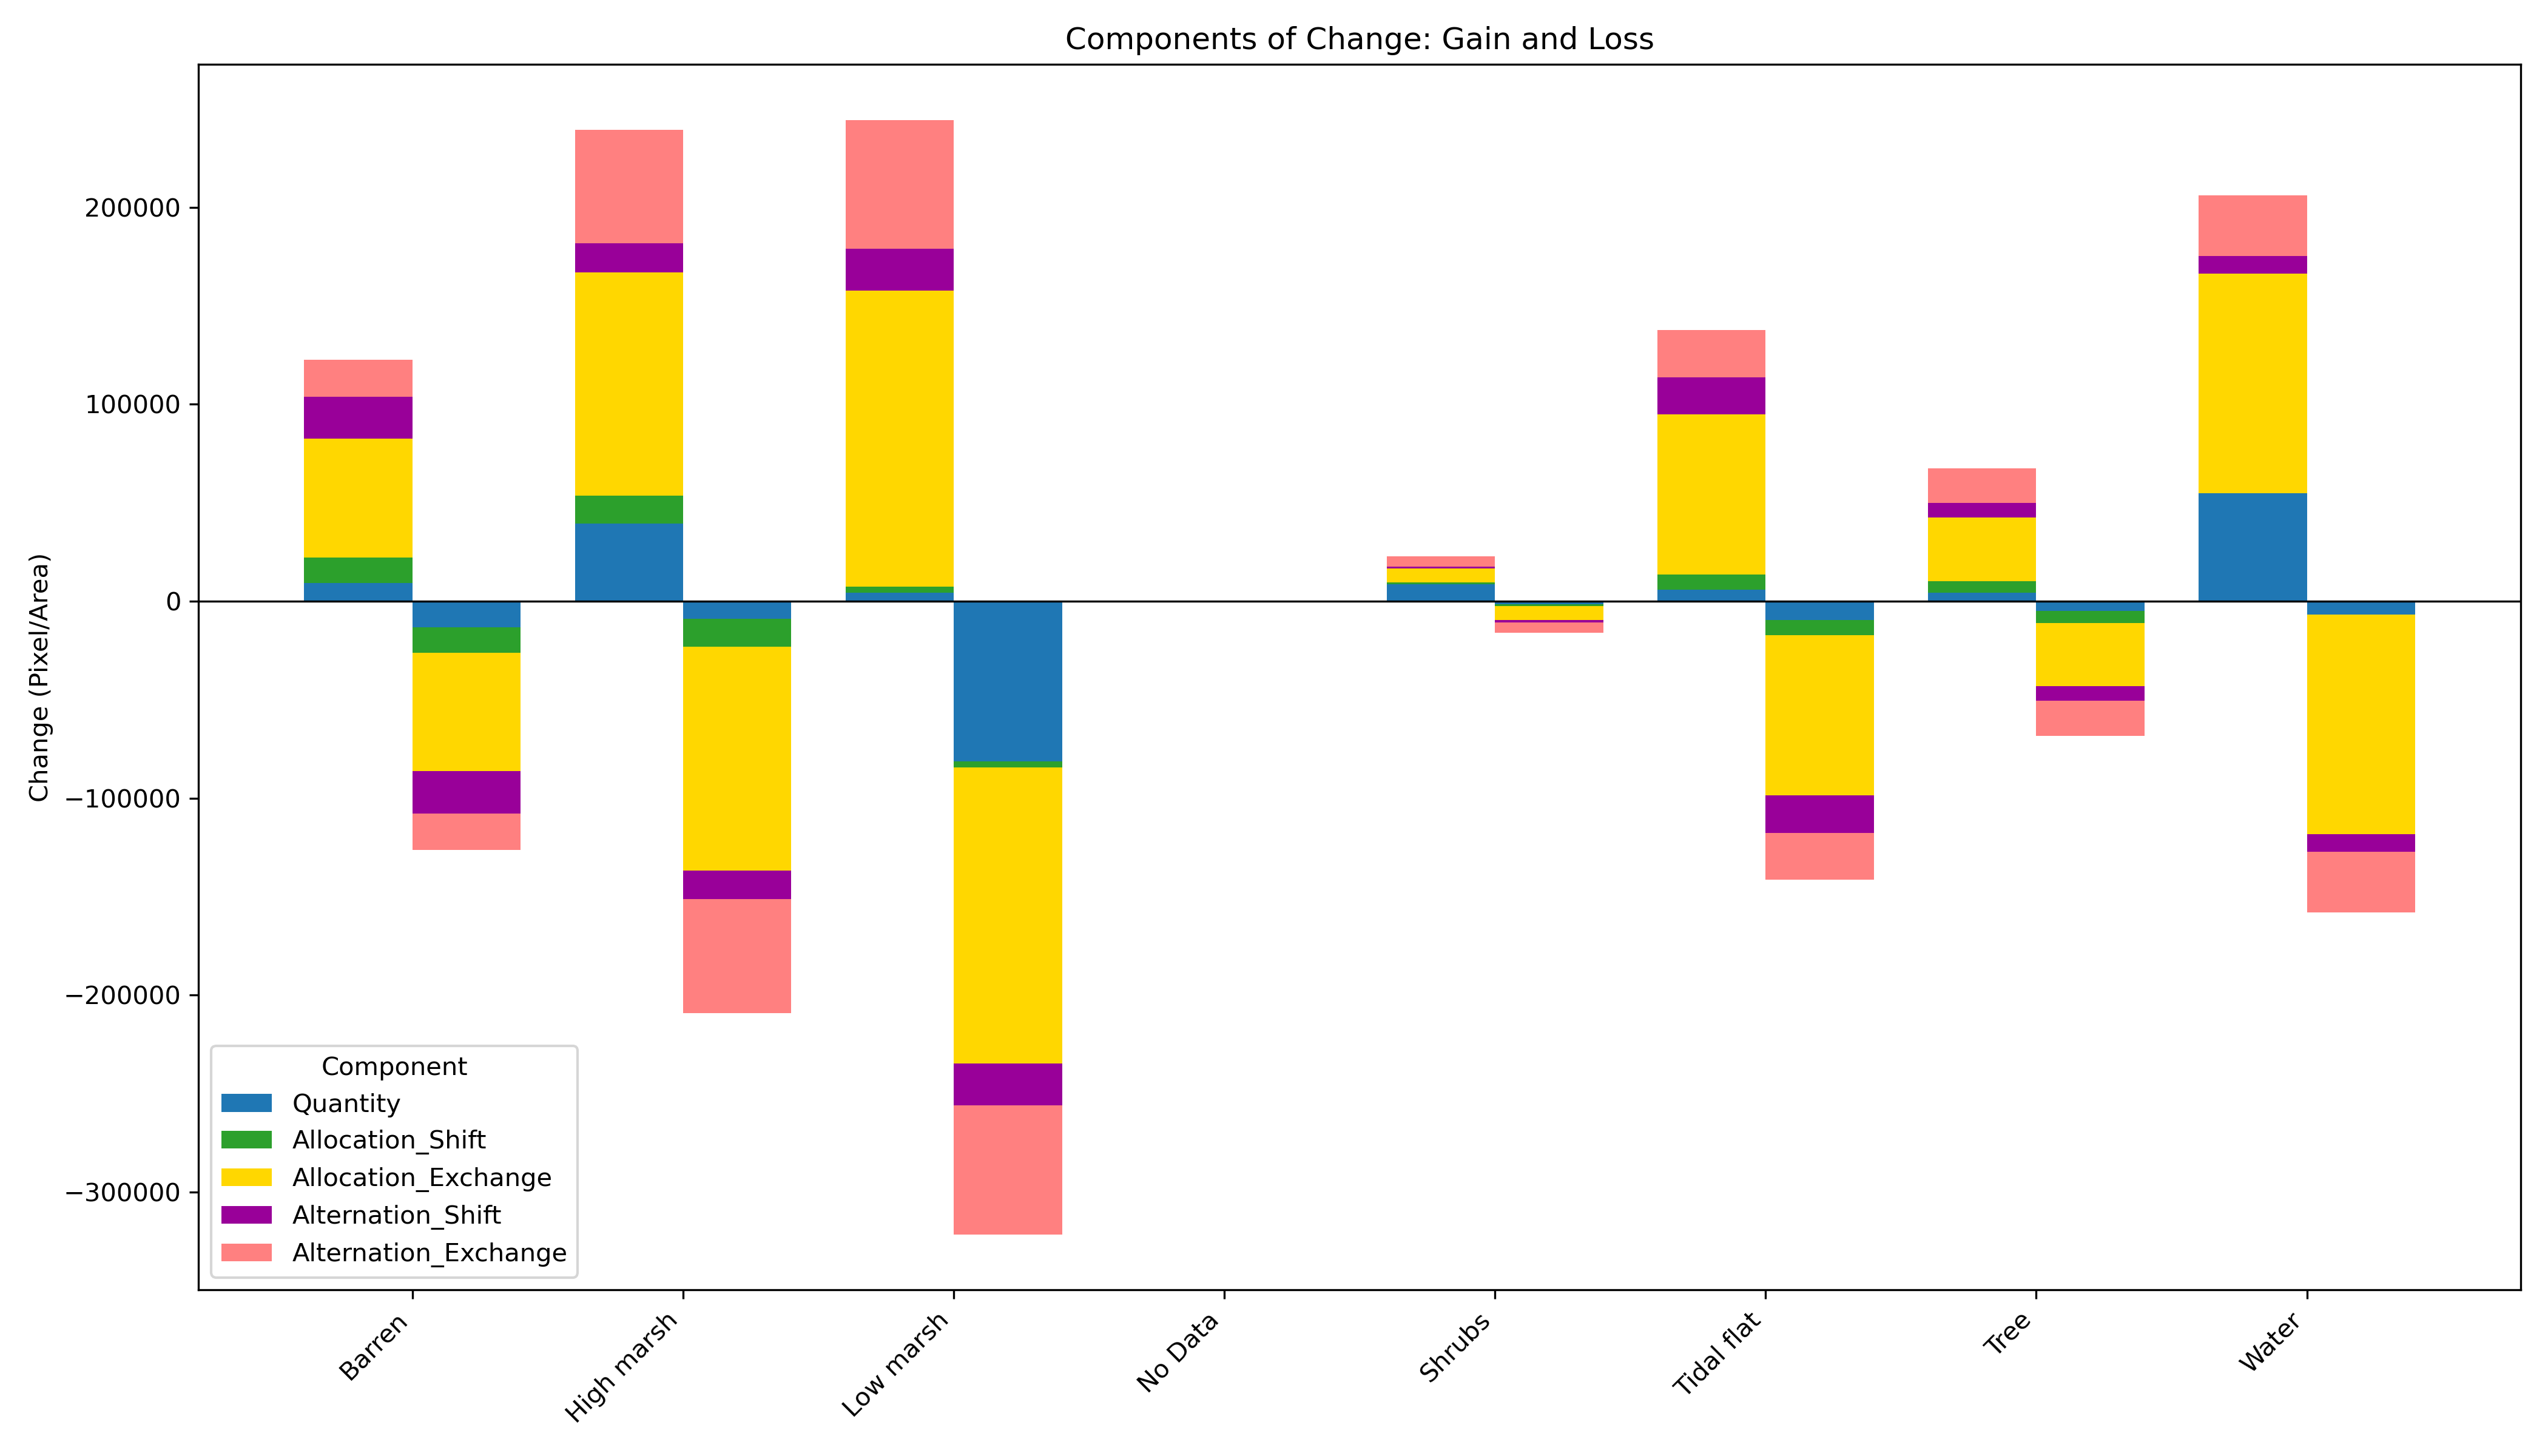

In [38]:
print("Plotting change components per category...")

# This function is imported from utils.py.
# It reads the 'df_components' DataFrame calculated in Section 5 and generates
# a stacked bar chart showing Gain/Loss for every class found in the data.
plot_change_components(
    components_df=df_components,
    class_labels=class_labels_dict,
    output_path=output_path,
    filename="graphic_change_components_per_class.png"
)

# Display the saved plot
import os
from IPython.display import Image
display(Image(filename=os.path.join(output_path, "graphic_change_components_per_class.png")))